## Exercise set 5: The Generalized Random Forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [55]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 5.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [56]:
N_SAMPLES = 10000
N_FEATURES = 5
GAMMA = 3
BETA = np.random.uniform(0,1, size = N_FEATURES)

X = np.random.normal(size = (N_SAMPLES, N_FEATURES)) # Covariates/features
D = np.random.choice([0,1], size = N_SAMPLES) # For random allocation of treatment effect
T = np.random.uniform(0,1, size = N_SAMPLES) > 0.5 # Treatment assignment

Y0 = X @ BETA + np.random.normal() # Relation between baseline outcome and covariates
X0 = X[:,0]
Tau = 10*(1 - D)/(1 + np.exp(-GAMMA*X0)) + np.random.normal() # Treatment effect
Y1 = Y0 + Tau # Endline outcome
y = Y0 + T*(Y1 - Y0) # Observed outcome

>**Ex. 5.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

**Answer:**

From the figure below, we see that the treatment effect is increasing in $X_0$, which makes sense since this is how we have created the data. We see $\tau=0$ in about half of the cases because we have made $\tau$ this way: Whenever $D=1$, $\tau$ just equals the noise term. So, I guess $\tau$ does not equal 0 but something close to 0. 

Text(0.5, 1.0, 'Treatment Effect vs. Covariates')

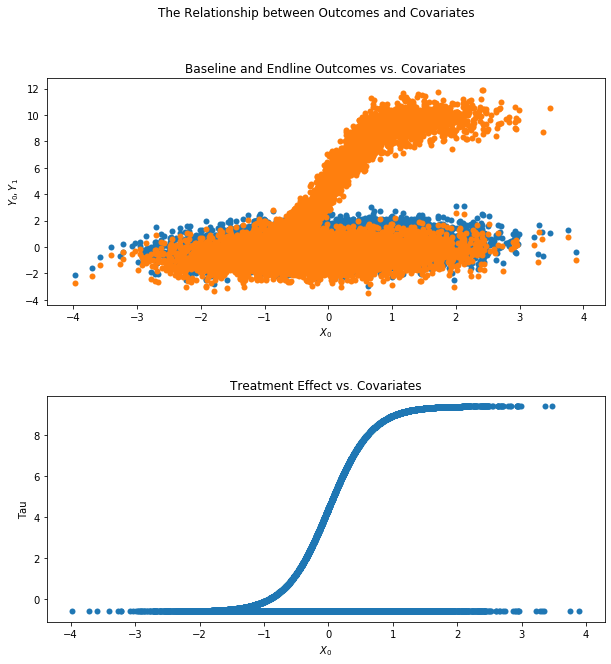

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make a figure with two subplots
fig, axes = plt.subplots(2, figsize=(10,10))

plt.suptitle("The Relationship between Outcomes and Covariates")
plt.subplots_adjust(wspace=0.3, hspace=0.4)

#  First subplot: Y0 and Y1 vs. X0
sns.scatterplot(
    x=X0, y=Y0,
    palette=sns.color_palette("hls", 10),
    linewidth=0,
    legend=None, 
    ax = axes[0]
)

sns.scatterplot(
    x=X0, y=Y1,
    palette=sns.color_palette("hls", 10),
    linewidth=0,
    legend=None, 
    ax = axes[0]
)

axes[0].set_ylabel("$Y_0, Y_1$")
axes[0].set_xlabel("$X_0$")
axes[0].set_title("Baseline and Endline Outcomes vs. Covariates")

#  Second subplot: Tau vs. X0
sns.scatterplot(
    x=X0, y=Tau,
    palette=sns.color_palette("hls", 10),
    linewidth=0,
    legend=None, 
    ax = axes[1]
)

axes[1].set_ylabel("Tau")
axes[1].set_xlabel("$X_0$")
axes[1].set_title("Treatment Effect vs. Covariates")

>**Ex 5.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** Fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

**Answer:**

As seen from the output of the code below, $\hat{\delta}_0=1.89$. The number seems to fit the figure pretty good, but it is hard to tell. 

Suggestion for improvements of the model: ...

In [84]:
import statsmodels.api as sm

# Make on array with exogenous variables including constant
exog = np.column_stack((T, X))
exog = sm.add_constant(exog)

# Estimate the linear regression model
linear_model = sm.OLS(y, exog)
res_linear = linear_model.fit()
print('Parameters: ', res_linear.params)
print(res_linear.summary())

Parameters:  [0.10788086 1.89107371 0.96442991 0.39613518 0.5140292  0.22402811
 0.38666389]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     735.2
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:24:54   Log-Likelihood:                -22841.
No. Observations:               10000   AIC:                         4.570e+04
Df Residuals:                    9993   BIC:                         4.575e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

>**Ex. 5.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [129]:
import pandas as pd

# Make DataFrame with X, y, T, D
df = pd.concat(
[
    pd.DataFrame(X, columns=[f'X{i}' for i in range(N_FEATURES)]),
    pd.DataFrame(y, columns=['y']),
    pd.DataFrame(T, columns=['T']),
    pd.DataFrame(D, columns=['D'])
], 
axis=1)

# Save DataFrame as csv
df.to_csv(r'C:\Users\sune-\OneDrive - Københavns Universitet\Økonomi\10. semester\SDS Econometrics and Machine Learning\Exercises\exercise_5_df.csv', index = True)

>**Ex. 5.1.5:** Open up R and read the data you just saved into a dataframe (or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

**Answer:** 

See Exercise_5_R for answers to Ex. 5.1.5, 5.1.6, and 5.1.7.

>**Ex. 5.1.6:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [130]:
# Your answer either here, or in R

>**Ex. 5.1.7:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [ ]:
# Your answer either here, or in R

>**Ex. 5.1.8:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

In [135]:
# Import individual treatment effects from Exercise_5_R
R_df = pd.read_csv('C:\\Users\\sune-\\OneDrive - Københavns Universitet\\Økonomi\\10. semester\\SDS Econometrics and Machine Learning\\Exercises\\exercise_5_tau.csv')

R_df

,Unnamed: 0,x
0,1,0.015884
1,2,-0.576320
2,3,-0.576271
3,4,-0.584371
4,5,2.260086
...,...,...
9995,9996,-0.565149
9996,9997,6.128665
9997,9998,6.312606
9998,9999,-0.581392


Text(0.5, 1.0, 'True vs. Estimated Individual Treatment Effects')

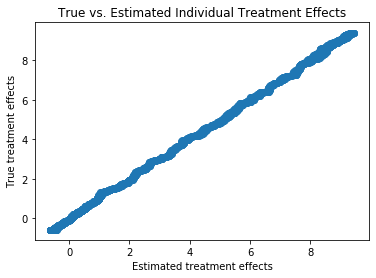

In [139]:
# Scatterplot of estimated treatment effects and true simulated treatment effects
te = R_df['x']

plt.scatter(te, Tau)
plt.ylabel("True treatment effects")
plt.xlabel("Estimated treatment effects")
plt.title("True vs. Estimated Individual Treatment Effects")